In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

A Support Vector Machine (SVM) is a very powerful and versatile Machine Learning model, capable of performing linear or nonlinear classification, regression, and even outlier detection. It is one of the most popular models in Machine Learning, and any‐ one interested in Machine Learning should have it in their toolbox. SVMs are partic‐ ularly well suited for classification of complex but small- or medium-sized datasets.

## Linear SVM Classification

You can think of an SVM classifier as fitting the widest possible street (represented by the parallel dashed lines) between the classes. This is called large margin classi cation.

In [3]:
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [10]:
iris = datasets.load_iris()
X = iris["data"][:, (2,3)] #petal length, petal width
y = (iris["target"] ==2).astype(np.float64) # iris-virginica

In [11]:
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1,loss="hinge")),

])

In [14]:
svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [15]:
svm_clf.predict([[5.5, 1.7]])

array([ 1.])

Unlike Logistic Regression classifiers, SVM classifiers do not out‐ put probabilities for each class.

Alternatively, you could use the SVC class, using SVC(kernel="linear", C=1), but it is much slower, especially with large training sets, so it is not recommended. 

Another option is to use the SGDClassifier class, with SGDClassifier(loss="hinge", alpha=1/(m*C)). This applies regular Stochastic Gradient Descent (see Chapter 4) to train a linear SVM classifier. It does not converge as fast as the LinearSVC class, but it can be useful to handle huge datasets that do not fit in memory (out-of-core training), or to handle online classification tasks.

The LinearSVC class regularizes the bias term, so you should center the training set first by subtracting its mean. This is automatic if you scale the data using the StandardScaler. Moreover, make sure you set the loss hyperparameter to "hinge", as it is not the default value. Finally, for better performance you should set the dual hyperparameter to False, unless there are more features than training instances (we will discuss duality later in the chapter).

## Non-Linear SVM Classification

Although linear SVM classifiers are efficient and work surprisingly well in many cases, many datasets are not even close to being linearly separable. One approach to handling nonlinear datasets is to add more features, such as polynomial features (as you did in Chapter 4); in some cases this can result in a linearly separable dataset.

To implement this idea using Scikit-Learn, you can create a Pipeline containing a PolynomialFeatures transformer (discussed in “Polynomial Regression” on page 121), followed by a StandardScaler and a LinearSVC. Let’s test this on the moons dataset (see Figure 5-6):

In [17]:
from sklearn.datasets import make_moons
#from sklearn.pipeline import Pipeline #already imported
from sklearn.preprocessing import PolynomialFeatures

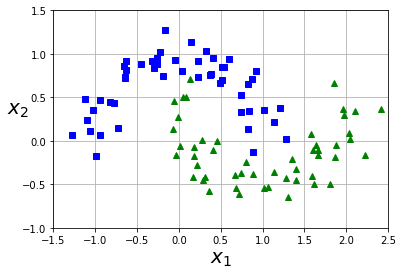

In [21]:
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [25]:
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()), 
    ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
])

In [26]:
polynomial_svm_clf.fit(X,y)

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

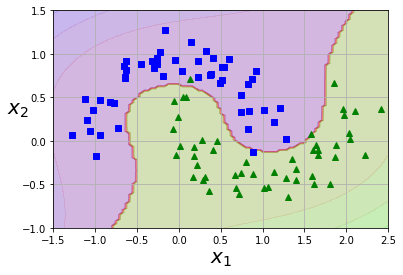

In [27]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

### Polynomial Kernel

Adding polynomial features is simple to implement and can work great with all sorts of Machine Learning algorithms (not just SVMs), but at a low polynomial degree it cannot deal with very complex datasets, and with a high polynomial degree it creates a huge number of features, making the model too slow.

Fortunately, when using SVMs you can apply an almost miraculous mathematical technique called the kernel trick (it is explained in a moment). It makes it possible to get the same result as if you added many polynomial features, even with very high- degree polynomials, without actually having to add them. So there is no combinato‐ rial explosion of the number of features since you don’t actually add any features. This trick is implemented by the SVC class. Let’s test it on the moons dataset:

In [28]:
from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline ([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])

In [29]:
poly_kernel_svm_clf.fit(X,y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

This code trains an SVM classifier using a 3rd-degree polynomial kernel. If your model is overfitting, you might want to
reduce the polynomial degree. Conversely, if it is underfitting, you can try increasing it. The hyperparameter coef0 controls how much the model is influenced by high- degree polynomials versus low-degree polynomials.

A common approach to find the right hyperparameter values is to use grid search (see Chapter 2). It is often faster to first do a very coarse grid search, then a finer grid search around the best values found. Having a good sense of what each hyperparameter actually does can also help you search in the right part of the hyperparame‐ ter space.

### Adding Similarity Features

Another technique to tackle nonlinear problems is to add features computed using a similarity function that measures how much each instance resembles a particular landmark. 

Let’s define the similarity function to be the Gaussian Radial Basis Function (RBF) with $\gamma$ = 0.3 

$$ \theta\gamma(x,l) = exp (-\gamma || x-l ||^2)$$

It is a bell-shaped function varying from 0 (very far away from the landmark) to 1 (at the landmark).

Let's choose two landmarks at $l_1 = -2$ and $l_2 = 1$. Say there is a feature at $x_1 = -1$ which is therefore a distance of 1 from the first landmark and 2 from the second. 

Therefore its new features are x2 = exp (–0.3 × 12) ≈ 0.74 and x3 = exp (–0.3 × 22) ≈ 0.30.

The plot on the right below shows the trans‐ formed dataset (dropping the original features). As you can see, it is now linearly separable.

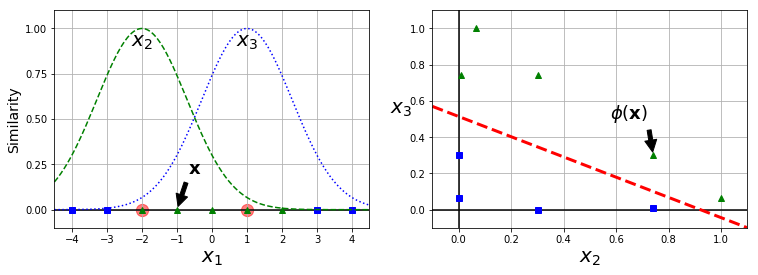

In [31]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

#save_fig("kernel_method_plot")
plt.show()

The simplest approach is to create a landmark at the location of each and every instance in the dataset. This creates many dimensions and thus increases the chances that the transformed training set will be linearly separable. The downside is that a training set with m instances and n features gets transformed into a training set with m instances and m features (assuming you drop the original features). If your training set is very large, you end up with an equally large number of features.

### Gaussian RBF Kernel

Just like the polynomial features method, the similarity features method can be useful with any Machine Learning algorithm, but it may be computationally expensive to compute all the additional features, especially on large training sets. However, once again the kernel trick does its SVM magic: it makes it possible to obtain a similar result as if you had added many similarity features, without actually having to add them. Let’s try the Gaussian RBF kernel using the SVC class:

In [32]:
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()), 
    ("svm_clf", SVC(kernel='rbf', gamma=5, C=0.001))
])

In [33]:
rbf_kernel_svm_clf.fit(X,y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

This model is represented on the bottom left of the figure below. The other plots show models trained with different values of hyperparameters gamma (γ) and C. Increasing gamma makes the bell-shape curve narrower, and as a result each instance’s range of influence is smaller: the decision boundary ends up being more irregular, wiggling around individual instances. Conversely, a small gamma value makes the bell-shaped curve wider, so instances have a larger range of influ‐ ence, and the decision boundary ends up smoother. So γ acts like a regularization hyperparameter: if your model is overfitting, you should reduce it, and if it is under‐ fitting, you should increase it (similar to the C hyperparameter).

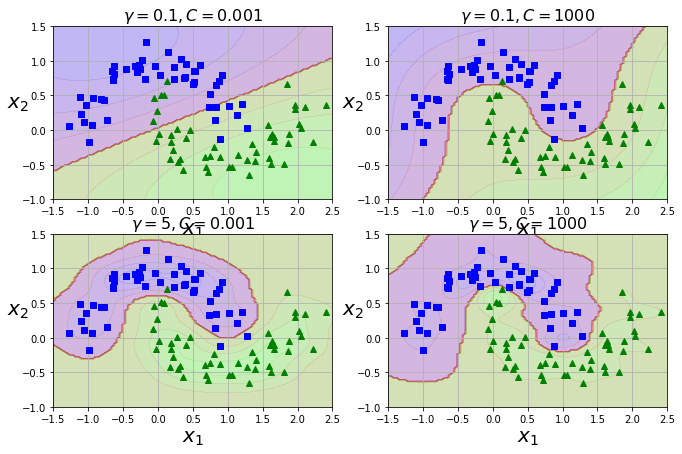

In [34]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(11, 7))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)

#save_fig("moons_rbf_svc_plot")
plt.show()

Other kernels exist but are used much more rarely. For example, some kernels are specialized for specific data structures. String kernels are sometimes used when classi‐ fying text documents or DNA sequences (e.g., using the string subsequence kernel or kernels based on the Levenshtein distance).

With so many kernels to choose from, how can you decide which one to use? As a rule of thumb, you should always try the linear kernel first (remember that LinearSVC is much faster than SVC(kernel="linear")), especially if the training set is very large or if it has plenty of features. If the training set is not too large, you should try the Gaussian RBF kernel as well; it works well in most cases. Then if you have spare time and computing power, you can also experiment with a few other kernels using cross-validation and grid search, especially if there are kernels specialized for your training set’s data structure.

### Computational Complexity

The LinearSVC class is based on the liblinear library, which implements an optimized algorithm for linear SVMs. It does not support the kernel trick, but it scales almost
linearly with the number of training instances and the number of features: its training time complexity is roughly O(m × n).
The algorithm takes longer if you require a very high precision. This is controlled by the tolerance hyperparameter ε (called tol in Scikit-Learn). In most classification tasks, the default 
tolerance is fine.

The SVC class is based on the libsvm library, which implements an algorithm that sup‐ ports the kernel trick. The training time complexity is usually between O(m2 × n) and O(m3 × n). Unfortunately, this means that it gets dreadfully slow when the num‐ ber of training instances gets large (e.g., hundreds of thousands of instances). This algorithm is perfect for complex but small or medium training sets. However, it scales well with the number of features, especially with sparse features (i.e., when each instance has few nonzero features). In this case, the algorithm scales roughly with the average number of nonzero features per instance. 

## SVM Regression

VM algorithm is quite versatile: not only does it sup‐ port linear and nonlinear classification, but it also supports linear and nonlinear regression. The trick is to reverse the objective: instead of trying to fit the largest pos‐ sible street between two classes while limiting margin violations, SVM Regression tries to fit as many instances as possible on the street while limiting margin violations (i.e., instances o  the street). The width of the street is controlled by a hyperparameter ε.

Adding more training instances within the margin does not affect the model’s predic‐ tions; thus, the model is said to be ε-insensitive.
You can use Scikit-Learn’s LinearSVR class to perform linear SVM Regression.

In [40]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [36]:
from sklearn.svm import LinearSVR

In [41]:
svm_reg = LinearSVR(epsilon=1.5,random_state=42)

In [42]:
svm_reg.fit(X,y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=42, tol=0.0001, verbose=0)

In [43]:

svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

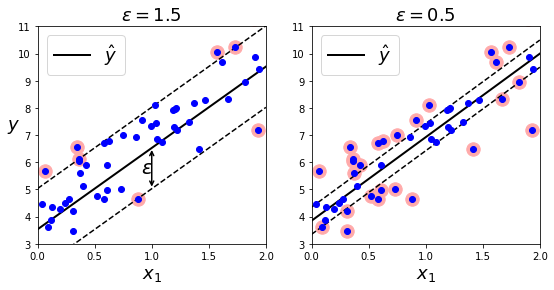

In [44]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.subplot(122)
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
#save_fig("svm_regression_plot")
plt.show()

To tackle nonlinear regression tasks, you can use a kernelized SVM model. For example, Figure below shows SVM Regression on a random quadratic training set, using a 2nd-degree polynomial kernel. There is little regularization on the left plot (i.e., a large C value), and much more regularization on the right plot (i.e., a small C value).

The following uses Scikit-Learn's SVR class, which supports the kernel trick. The SVR class is the regres‐ sion equivalent of the SVC class, and the LinearSVR class is the regression equivalent of the LinearSVC class. The LinearSVR class scales linearly with the size of the train‐ ing set (just like the LinearSVC class), while the SVR class gets much too slow when the training set grows large (just like the SVC class).

In [45]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [46]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1)
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

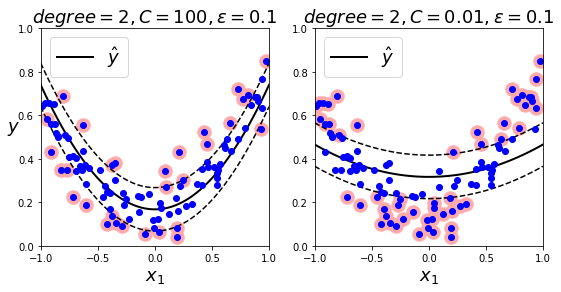

In [47]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.subplot(122)
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
#save_fig("svm_with_polynomial_kernel_plot")
plt.show()